In [1]:
import torch
import torch.nn as nn
from transformers import (
    EarlyStoppingCallback, Wav2Vec2FeatureExtractor, Wav2Vec2Processor, 
    TrainingArguments, Trainer, AutoConfig, AutoModelForCTC, Wav2Vec2PhonemeCTCTokenizer, AutoFeatureExtractor, Wav2Vec2Model, HubertModel, WavLMModel )
from datasets import load_from_disk
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from tqdm import tqdm
import pandas as pd


/home/haeyoung/anaconda3/envs/s3prl38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# for general, freeze
class PronunciationScoringModel(nn.Module):
    def __init__(self, model_name, model_save_path=None):
        super().__init__()
        config = AutoConfig.from_pretrained(model_name)
        if 'wav2vec2' in model_name:
            self.model = Wav2Vec2Model.from_pretrained(model_name, config=config)
        elif 'hubert' in model_name:
            self.model = HubertModel.from_pretrained(model_name, config=config)
        elif 'wavlm' in model_name:
            self.model = WavLMModel.from_pretrained(model_name, config=config)
        else:
            raise ValueError(f"Unsupported model type for model name: {model_name}")
        self.score_predictor = nn.Linear(config.hidden_size, 4)  # Additional linear layer for scoring

    def forward(self, input_values):
        outputs = self.model(input_values=input_values)
        last_hidden_state = outputs.last_hidden_state
        scores = self.score_predictor(last_hidden_state.mean(dim=1))
        return scores

In [ ]:
# for ctc
class PronunciationScoringModelforCTC(nn.Module):
    def __init__(self, model_name, model_save_path=None):
        super().__init__()
        
        config = AutoConfig.from_pretrained(model_name)
        self.model = AutoModelForCTC.from_pretrained(model_name)        
        self.score_predictor = nn.Linear(32, 4)
        
    def forward(self, input_values, labels=None, output_hidden_states=True, return_dict=True):
        outputs = self.model(input_values=input_values, 
                             output_hidden_states=output_hidden_states, 
                             return_dict=return_dict)
        logits = outputs.logits
        hidden_states = outputs.hidden_states[-1]
        pooled_output = logits.mean(dim=1)
        scores = self.score_predictor(pooled_output).squeeze(-1)
        return scores

In [ ]:

test_ds_path = "/data2/haeyoung/speechocean762/preprocess/speechocean_test_ds"
test_ds = load_from_disk(test_ds_path)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

def extract_scores(model, feature_extractor, batch):
    input_values = feature_extractor(batch["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values.to("cuda")
    with torch.no_grad():
        scores_pred  = model(input_values)
        scores_numpy = scores_pred.cpu().detach().numpy()
    return scores_numpy

def get_labels(batch):
    labels = np.zeros([4])
    labels[0] = batch['accuracy']
    labels[1] = batch['fluency']
    labels[2] = batch['prosodic']
    labels[3] = batch['total']
    
    return labels

def compute_metrics(preds, labels):
    mse = mean_squared_error(labels, preds, multioutput='raw_values')
    pcc = [np.corrcoef(labels[:, i], preds[:, i])[0, 1] if not np.isnan(np.corrcoef(labels[:, i], preds[:, i])[0, 1]) else 0 for i in range(preds.shape[1])]

    metrics = {}
    for i, (mse_val, pcc_val) in enumerate(zip(mse, pcc)):
        metrics[f"mse_{i}"] = mse_val
        metrics[f"pcc_{i}"] = pcc_val

    return metrics


In [6]:
labels = [get_labels(batch) for batch in tqdm(test_ds)]
all_labels = np.vstack(labels)

  7%|▋         | 180/2500 [00:00<00:02, 885.02it/s]

100%|██████████| 2500/2500 [00:01<00:00, 1587.90it/s]


In [7]:
all_labels.shape

(2500, 4)

In [8]:
all_labels[:20]

array([[ 9.,  9.,  9.,  9.],
       [ 7.,  9.,  9.,  7.],
       [ 9.,  9.,  9.,  9.],
       [ 8.,  9.,  8.,  7.],
       [ 9.,  9.,  9.,  9.],
       [ 7., 10.,  9.,  7.],
       [ 8.,  9.,  9.,  8.],
       [ 8.,  9.,  8.,  8.],
       [ 8.,  9.,  8.,  8.],
       [ 9.,  9.,  9.,  9.],
       [ 8.,  9.,  8.,  8.],
       [ 9.,  9.,  8.,  8.],
       [ 7.,  9.,  8.,  7.],
       [ 9., 10.,  9.,  9.],
       [ 9.,  9.,  9.,  8.],
       [ 9.,  9.,  9.,  8.],
       [ 8.,  9.,  9.,  8.],
       [ 9.,  9.,  8.,  8.],
       [ 9.,  9.,  7.,  8.],
       [10., 10., 10.,  9.]])

In [11]:
labels_df = pd.DataFrame(all_labels, columns=['accuracy', 'fluency', 'prosodic', 'total'])
expanded_labels_df = pd.concat([labels_df] , ignore_index=True)

expanded_labels_df

,accuracy,fluency,prosodic,total
0,9.0,9.0,9.0,9.0
1,7.0,9.0,9.0,7.0
2,9.0,9.0,9.0,9.0
3,8.0,9.0,8.0,7.0
4,9.0,9.0,9.0,9.0
...,...,...,...,...
2495,5.0,3.0,3.0,4.0
2496,6.0,6.0,5.0,5.0
2497,4.0,3.0,3.0,3.0
2498,5.0,5.0,4.0,4.0


In [ ]:
path = "/home/haeyoung/analysis/score/"
df_pt = pd.read_csv(path+'ptwavlm_speaker-diarization.csv')

In [ ]:
combined_df = pd.concat([df_pt, expanded_labels_df], axis=1)
combined_df

,0,1,2,3,4,5,6,7,8,9,...,763,764,765,766,767,model_name,accuracy,fluency,prosodic,total
0,0.003720,0.059743,-0.059013,-0.011709,-0.018543,0.012418,-0.114520,-0.016948,0.016917,0.053662,...,-0.021230,-0.022088,0.010559,0.049487,0.629889,ptwavlm_speaker-diarization,9.0,9.0,9.0,9.0
1,0.035178,0.018381,-0.055282,-0.008320,-0.020021,0.014783,-0.040551,-0.084823,0.001700,0.051161,...,-0.004955,-0.014451,-0.013396,0.028340,0.695965,ptwavlm_speaker-diarization,7.0,9.0,9.0,7.0
2,0.033125,0.069117,-0.067643,-0.024552,-0.033821,0.015118,-0.070278,-0.065619,-0.012551,0.055762,...,0.003304,-0.063400,-0.000200,0.038066,0.544352,ptwavlm_speaker-diarization,9.0,9.0,9.0,9.0
3,0.025982,0.066771,-0.070063,-0.005115,-0.027203,-0.000257,-0.074424,-0.053169,-0.019542,0.038539,...,-0.023422,-0.019299,0.006343,0.024136,0.588463,ptwavlm_speaker-diarization,8.0,9.0,8.0,7.0
4,0.035517,0.040842,-0.040955,0.014728,-0.031849,0.024755,-0.068668,-0.103455,0.004985,0.059214,...,-0.028202,-0.024009,-0.015841,0.054467,0.708561,ptwavlm_speaker-diarization,9.0,9.0,9.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.009627,0.005423,0.004029,-0.013689,0.006017,0.045185,-0.077686,-0.042122,0.018476,0.039723,...,0.022646,0.004108,0.003340,0.004057,0.752723,ptwavlm_speaker-diarization,5.0,3.0,3.0,4.0
2496,-0.002506,0.011075,0.000844,0.000349,-0.037779,0.028855,-0.106872,-0.029518,0.004450,0.015458,...,0.013103,0.014474,-0.015997,0.028811,0.680187,ptwavlm_speaker-diarization,6.0,6.0,5.0,5.0
2497,0.007878,0.002417,-0.018012,-0.014692,-0.030804,0.021404,-0.095627,-0.033551,0.022224,0.061010,...,0.034716,0.021199,-0.022496,0.012640,0.944864,ptwavlm_speaker-diarization,4.0,3.0,3.0,3.0
2498,0.012037,0.015380,-0.028989,0.015567,-0.033416,0.048360,-0.100109,-0.026342,-0.008014,0.059441,...,0.031079,-0.007767,-0.025486,0.011533,0.861911,ptwavlm_speaker-diarization,5.0,5.0,4.0,4.0


In [162]:
df2 = combined_df
X = df2.drop(['model_name', 'accuracy', 'fluency', 'prosodic', 'total'], axis=1)
Y = df2[['accuracy']]

In [ ]:
features = X.T 
covariance_matrix = np.cov(features)
eig_vals, eig_vecs = np.linalg.eig(covariance_matrix)
key = eig_vals[0] / sum(eig_vals)
print(key)

0.09750965074762775


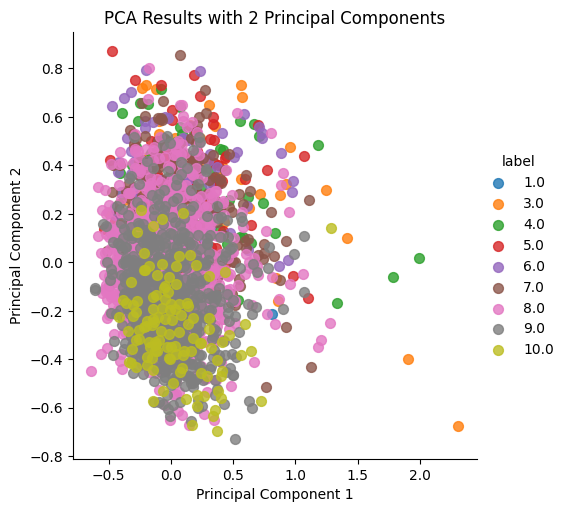

In [ ]:


from sklearn import decomposition
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pca = decomposition.PCA(n_components=2)
pca_result = pca.fit_transform(X)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['label'] = Y
sns.lmplot(x='PC1', y='PC2', data=pca_df, fit_reg=False, scatter_kws={"s": 50}, hue="label")
plt.title('PCA Results with 2 Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

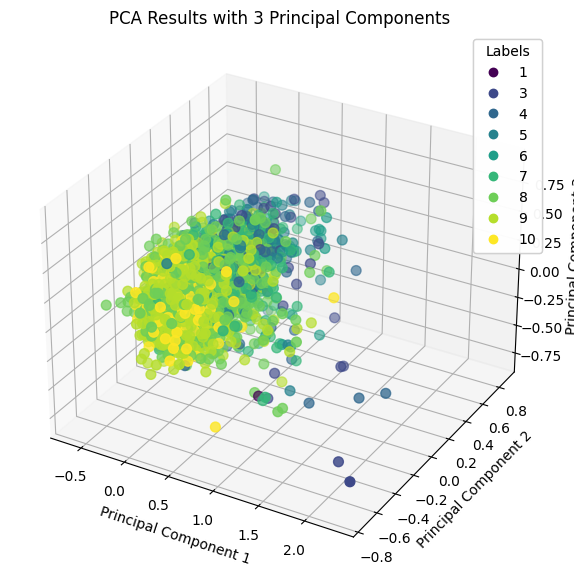

In [ ]:
from sklearn import decomposition
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pca = decomposition.PCA(n_components=3)
pca_result = pca.fit_transform(X)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])
pca_df['label'] = Y
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['label'], cmap='viridis', s=50)
legend1 = ax.legend(*scatter.legend_elements(), title="Labels")
ax.add_artist(legend1)
ax.set_title('PCA Results with 3 Principal Components')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()
